In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.clear()

dout = 'check_gnn/'

In [3]:
signal_trees = TreeIter( [ Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_900_MY_400)] )
gnn_signal_trees = TreeIter([ Tree(fc.eightb.preselection_gnn.NMSSM_XYY_YToHH_8b_MX_900_MY_400) ])

In [4]:
qcd_trees = TreeIter( [ Tree(fc.eightb.preselection.QCD_B_List)] )
gnn_qcd_trees = TreeIter([ Tree(filter(lambda f : os.path.isfile(f),fc.eightb.preselection_gnn.QCD_B_List)) ])

In [5]:
all_trees = signal_trees + gnn_signal_trees + qcd_trees + gnn_qcd_trees 
# all_trees = signal_trees + gnn_signal_trees
all_signal_trees = signal_trees + gnn_signal_trees
all_qcd_trees = qcd_trees + gnn_qcd_trees

trees = signal_trees + qcd_trees
gnn_trees = gnn_signal_trees + gnn_qcd_trees 

In [6]:
def build_ptordered_collection(tree,pattern,name):
    collection = build_collection(tree,pattern,name)
    order = ak.argsort(-collection[f'{name}_pt'],axis=-1)
    for name,array in collection.items():
        collection[name] = array[order]
    return collection

In [7]:
all_trees.extend(kwargs = lambda tree : build_ptordered_collection(tree,'H\dY\d_b\d','bjet'))
all_trees.extend(kwargs = lambda tree : build_ptordered_collection(tree,'H\dY\d','higgs'))
all_trees.extend(kwargs = lambda tree : build_ptordered_collection(tree,'Y\d','y'))


In [8]:
def count_signal_objs(tree):
    nfound_h = ak.sum((tree.higgs_b1_genHflag == tree.higgs_b2_genHflag) & (tree.higgs_b1_genHflag != -1) & (tree.higgs_b2_genHflag != -1),axis=-1)
    nfound_selected = ak.sum(tree.bjet_genHflag > -1,axis=-1)
    
    tree.extend(nfound_h=nfound_h,nfound_selected=nfound_selected)

In [9]:
all_signal_trees.apply(count_signal_objs)

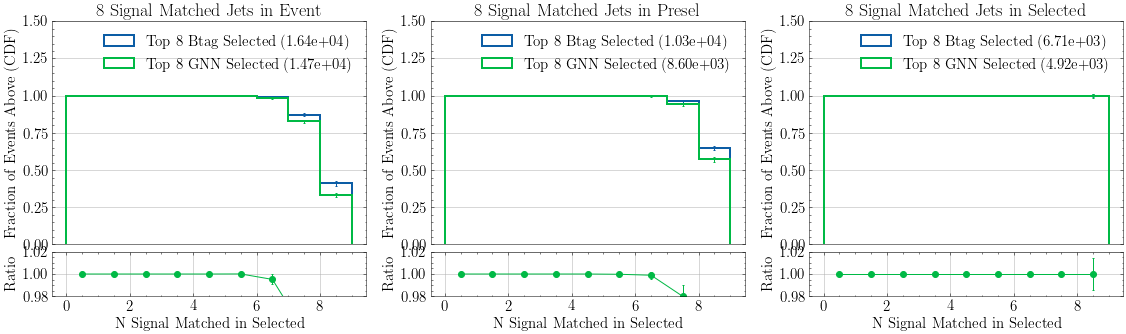

In [10]:
masks = (
     lambda tree : tree.nfound_all == 8,
     lambda tree : tree.nfound_presel == 8,
     lambda tree : tree.nfound_selected == 8
 )

masknames = ["8 Signal Matched Jets in Event","8 Signal Matched Jets in Presel","8 Signal Matched Jets in Selected"]
labels=["Top 8 Btag Selected","Top 8 GNN Selected"]
xlabel="N Signal Matched in Selected"

fig,axs = plt.subplots(ncols=3,figsize=(16,5))

for i,(mask,name) in enumerate(zip(masks,masknames)):
    hist_multi(
           [ array[mask] for array,mask in zip(all_signal_trees.nfound_selected,all_signal_trees.apply(mask)) ],
           labels=labels,
           xlabel=xlabel,
           title=name,
           grid=True,
           cumulative=-1,
           ratio=True,
           r_inv=True,
           r_ylim=(0.98,1.02),
           figax=(fig,axs[i])
        )
    
fig.tight_layout()

study.save_fig(fig,dout,'signal_jet_eff')

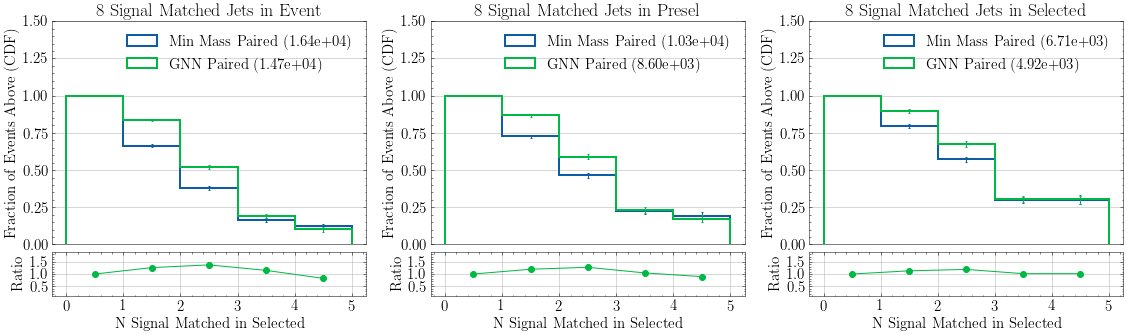

In [11]:
masks = (
     lambda tree : tree.nfound_all == 8,
     lambda tree : tree.nfound_presel == 8,
     lambda tree : tree.nfound_selected == 8
 )

masknames = ["8 Signal Matched Jets in Event","8 Signal Matched Jets in Presel","8 Signal Matched Jets in Selected"]
labels=["Min Mass Paired","GNN Paired"]
xlabel="N Signal Matched in Selected"

fig,axs = plt.subplots(ncols=3,figsize=(16,5))

for i,(mask,name) in enumerate(zip(masks,masknames)):
    hist_multi(
           [ array[mask] for array,mask in zip(all_signal_trees.nfound_h,all_signal_trees.apply(mask)) ],
           labels=labels,
           xlabel=xlabel,
           title=name,
           grid=True,
           cumulative=-1,
           ratio=True,
           r_inv=True,
        #    r_ylim=(0.55,1.45),
           figax=(fig,axs[i])
        )
    
fig.tight_layout()

study.save_fig(fig,dout,'signal_higgs_eff')

In [25]:
varinfo.higgs_m = dict(bins=np.linspace(0,500,30))
varinfo.higgs_dm = dict(bins=np.linspace(0,300,30))

In [ ]:
def delta_mean(array,mean):
    array = array.to_numpy()
    delta = np.abs(array - mean)
    return ak.from_regular(delta,axis=-1)

In [38]:
def array_std(array):
    array = array.to_numpy()
    return ak.from_regular(np.std(array,axis=-1))

In [53]:
def array_spread(array):
    array = array.to_numpy()
    return ak.from_regular(np.max(array,axis=-1) - np.min(array,axis=-1))

In [59]:
def get_higgs_dm(tree,mean):
    tree.extend(
        higgs_dm = delta_mean(tree.higgs_m,mean),
        higgs_stdm= array_std(tree.higgs_m),
        higgs_spread=array_spread(tree.higgs_m),
        y_spread = array_spread(tree.y_m)
        )

In [60]:
signal_means = list(map(lambda array : np.mean(array.to_numpy(),axis=0),all_signal_trees.higgs_m))

In [61]:
trees.apply(lambda t : get_higgs_dm(t,signal_means[0]))
gnn_trees.apply(lambda t : get_higgs_dm(t,signal_means[1]))


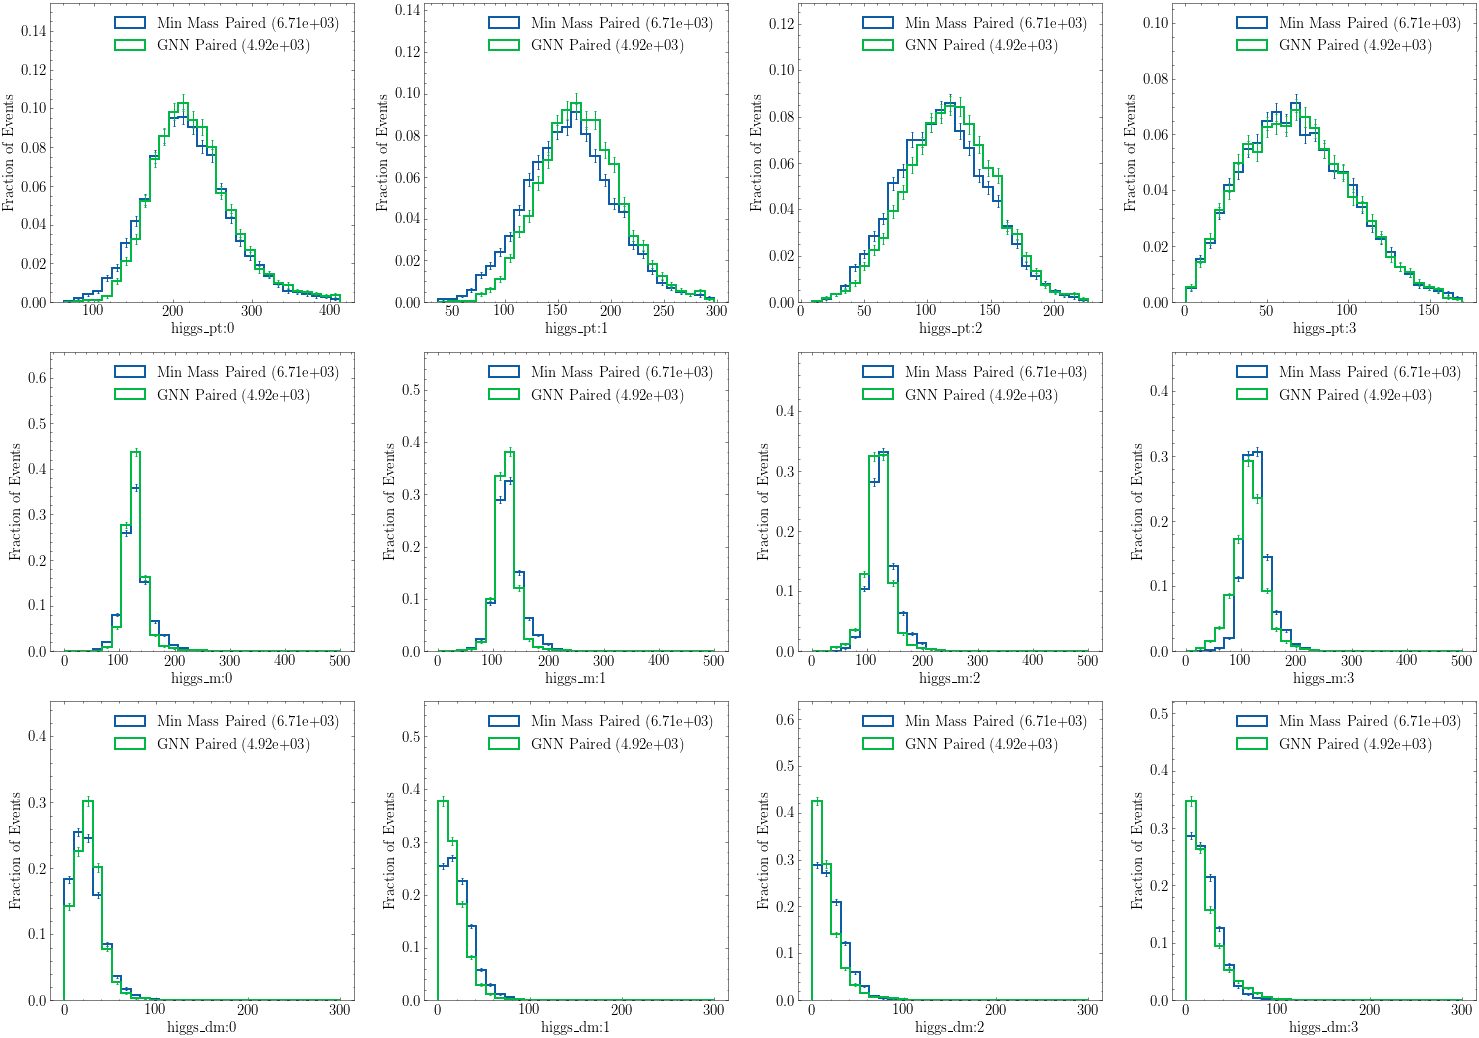

In [43]:
labels=["Min Mass Paired","GNN Paired"]
fig, axs = study.quick(
   all_signal_trees,
   masks=lambda tree : tree.nfound_selected == 8,
   varlist=[f"higgs_{var}:{higgs}" for var in ('pt','m','dm') for higgs in range(4)], 
   labels=labels,
   s_colors=None,
   density=True, 
   scale=False,
   dim=(-1,4),
)


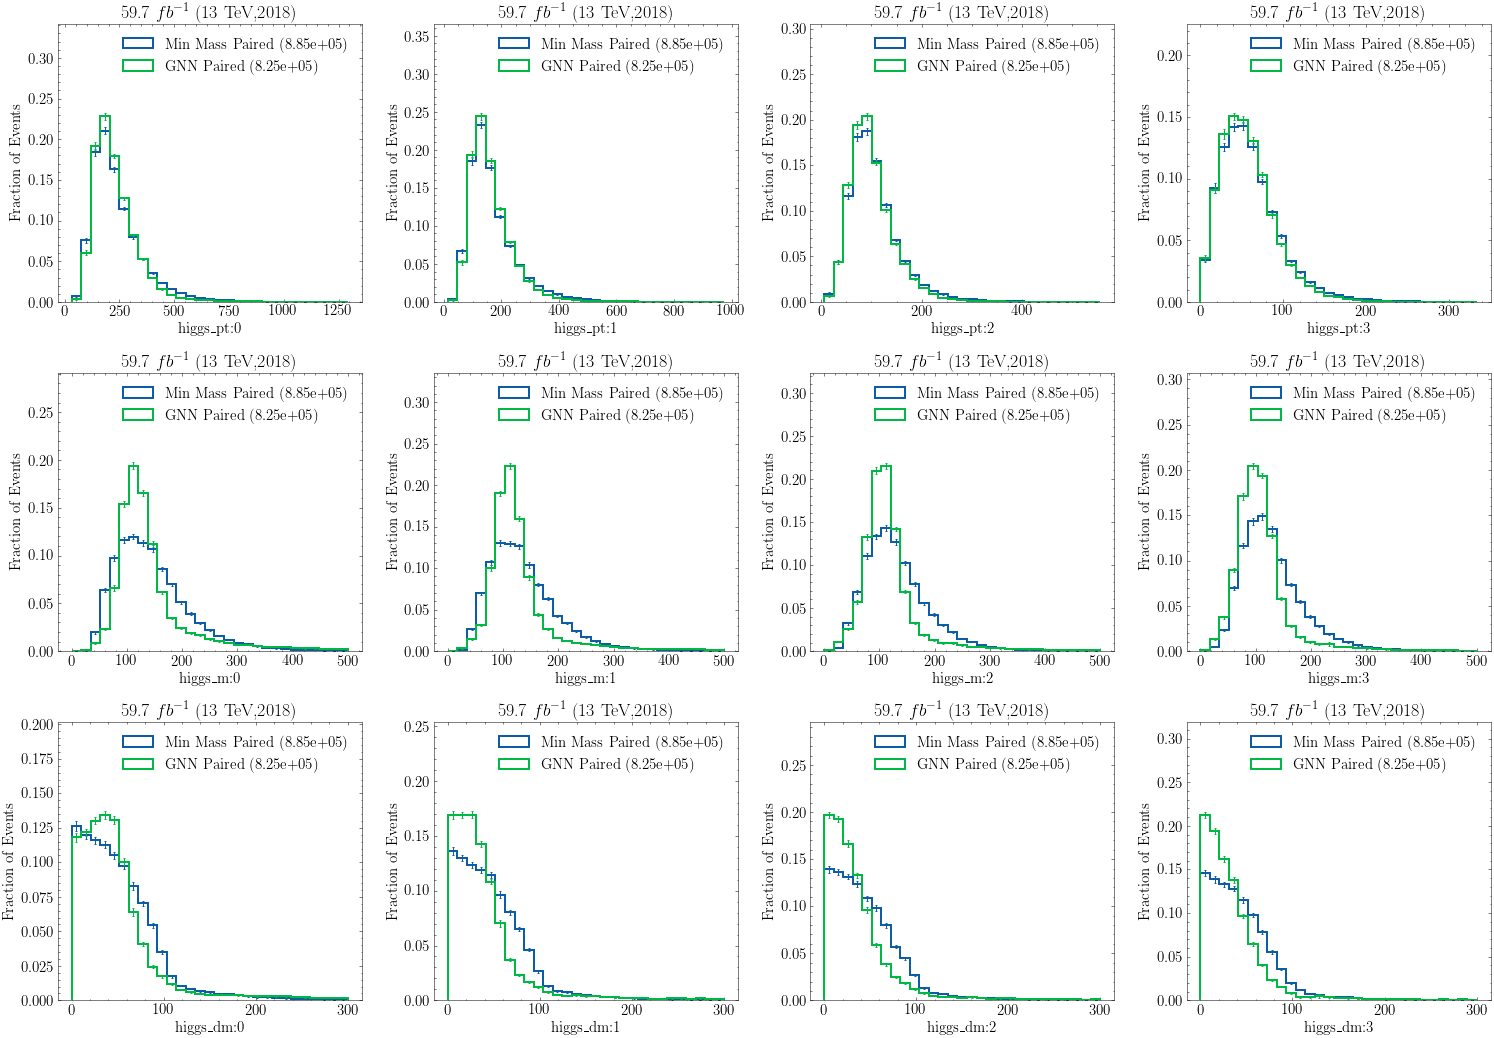

In [44]:
labels=["Min Mass Paired","GNN Paired"]
fig, axs = study.quick(
   all_qcd_trees,
   # masks=lambda tree : tree.nfound_selected == 8,
   varlist=[f"higgs_{var}:{higgs}" for var in ('pt','m','dm') for higgs in range(4)], 
   labels=labels,
   s_colors=None,
   density=True, 
   # scale=False,
   dim=(-1,4),
)


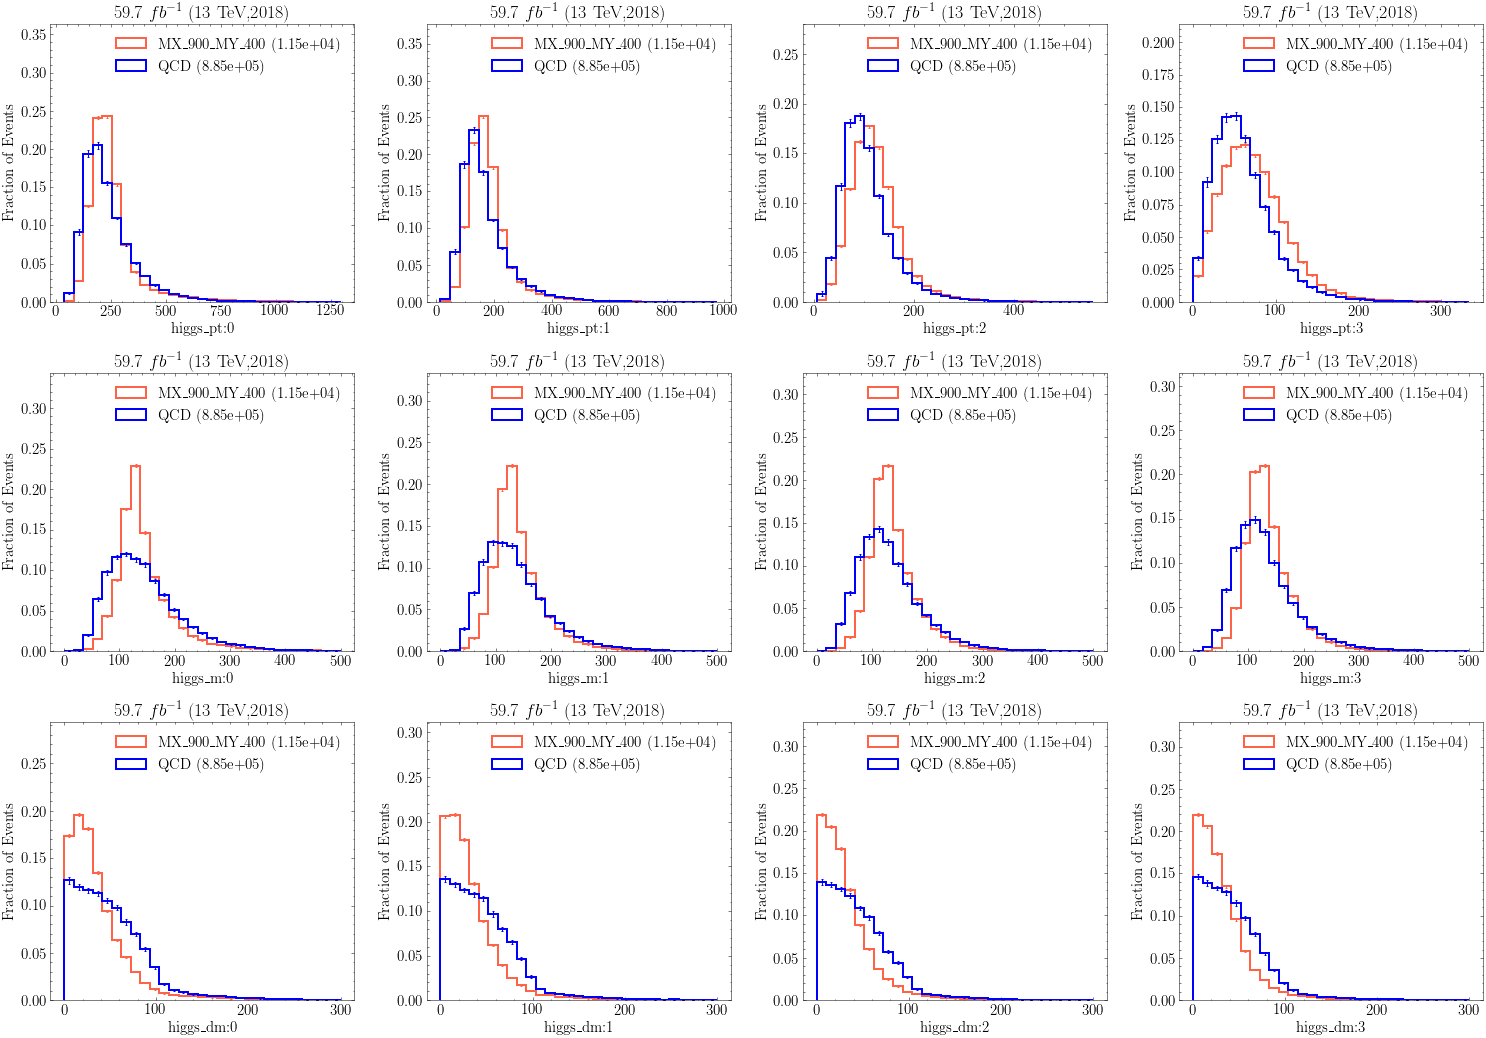

In [45]:
fig, axs = study.quick(
   trees,
   # masks=lambda tree : tree.nfound_selected == 8,
   varlist=[f"higgs_{var}:{higgs}" for var in ('pt','m','dm') for higgs in range(4)], 
   density=True, 
   # scale=False,
   dim=(-1,4),
)

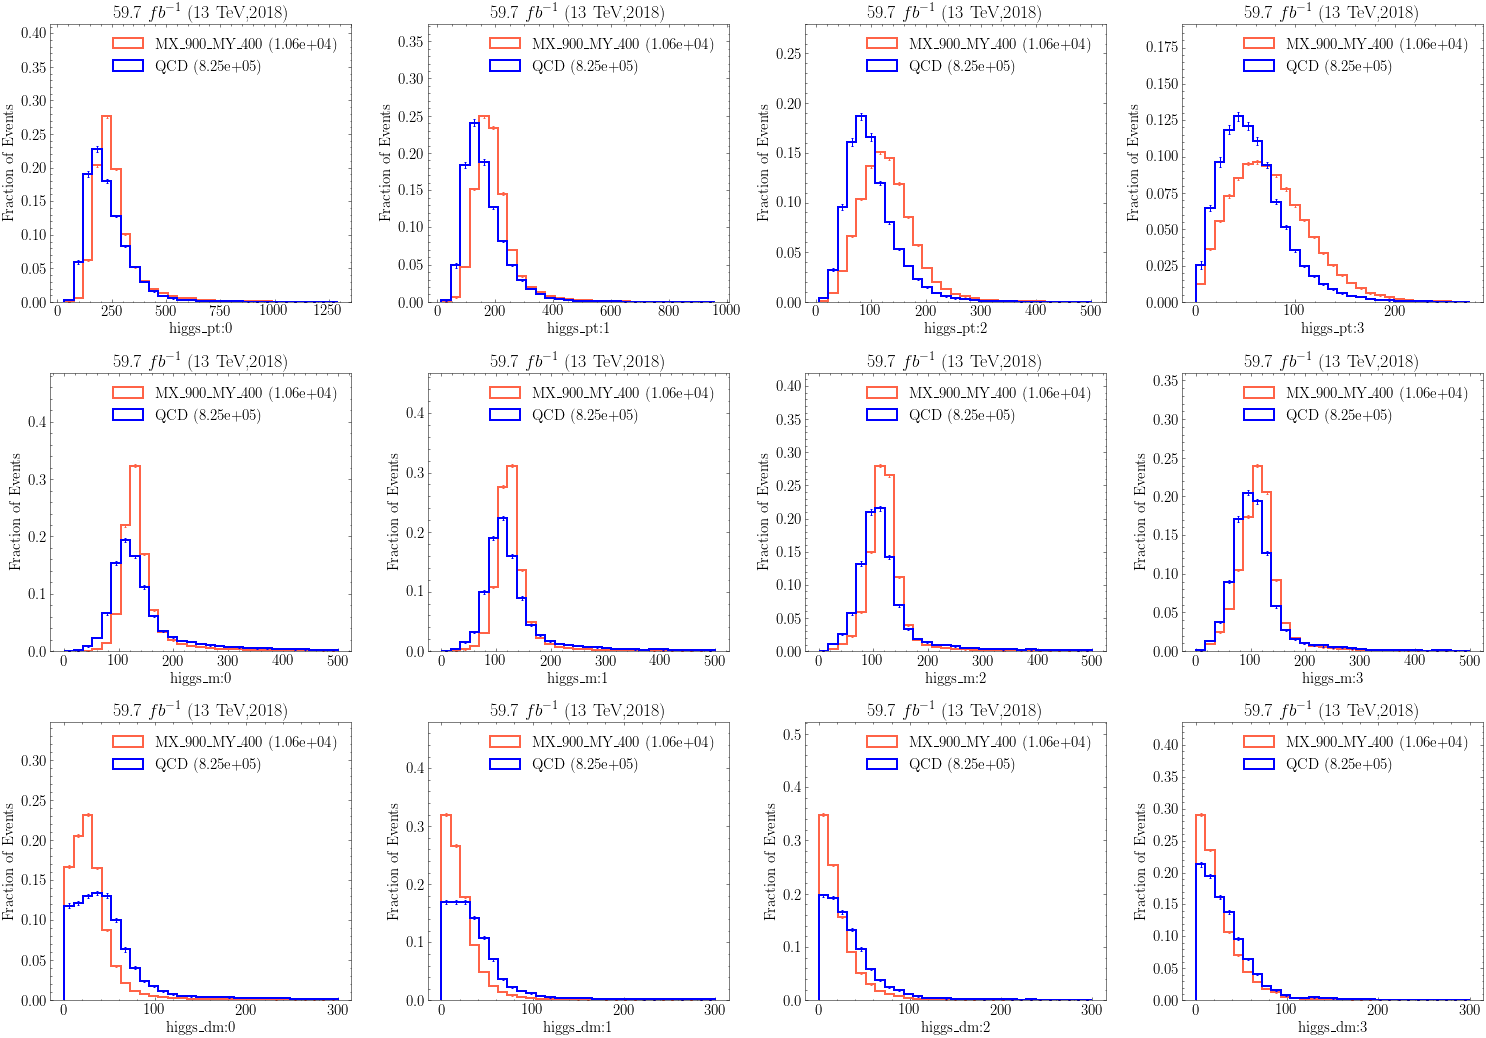

In [46]:
fig, axs = study.quick(
   gnn_trees,
   # masks=lambda tree : tree.nfound_selected == 8,
   varlist=[f"higgs_{var}:{higgs}" for var in ('pt','m','dm') for higgs in range(4)], 
   density=True, 
   # scale=False,
   dim=(-1,4),
)

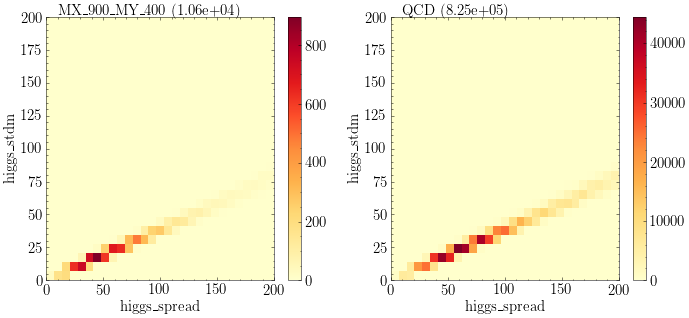

(<Figure size 720x360 with 4 Axes>,
 array([<AxesSubplot:xlabel='higgs_spread', ylabel='higgs_stdm'>,
        <AxesSubplot:xlabel='higgs_spread', ylabel='higgs_stdm'>],
       dtype=object))

In [66]:
varinfo.higgs_stdm = dict(bins=np.linspace(0,200,30))
varinfo.higgs_spread = dict(bins=np.linspace(0,200,30))
varinfo.y_spread = dict(bins=np.linspace(0,500,30))

study.quick2d(
    gnn_trees,
    varlist=['higgs_spread','higgs_stdm']
)